In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import trompy as tp

from scipy import stats

import dill

rcParams['font.family'] = 'Arial'
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.transparent'] = True
colors = ["#67AFD2", "#016895", "#F4795B", "#C74632"]
custom_cmap = LinearSegmentedColormap.from_list("custom_diverging", [colors[1], "white", colors[3]])

savefigs = True

DATAFOLDER = Path("..//data")
RESULTSFOLDER = Path("..//results")
FIGSFOLDER = Path("C:/Users/jmc010/Dropbox/Publications in Progress/Bazzino Roitman_sodium/figs")

In [21]:
with open(DATAFOLDER / "bazzino_data.pickle", "rb") as f:
    data = dill.load(f)

x_array = data["x_array"]
snips_photo = data["snips_photo"]
snips_vel = data["snips_vel"]

In [22]:
auc_snips = snips_photo[:, 50:150].mean(axis=1)
auc_vel = snips_vel[:, 50:150].mean(axis=1)
auc_vel.shape, auc_snips.shape

df = pd.DataFrame({"auc_snips": auc_snips, "auc_vel": auc_vel}).dropna(axis='rows')
x_array = pd.concat([x_array, df], axis=1)

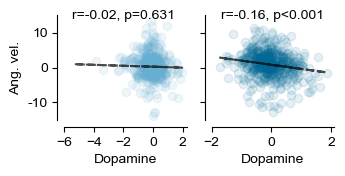

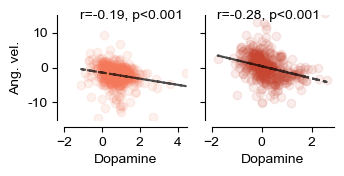

In [92]:
def make_da_vel_correlation_plot(x_array, condition, infusiontype, color="k", ax=None, yaxis=False):
    if ax is None:
        f, ax = plt.subplots()

    df2 = x_array.query("infusiontype == @infusiontype & condition == @condition")
    x = df2.auc_snips
    y = df2.auc_vel

    ax.scatter(x, y, alpha=0.1, color=color)

    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    y_fit = slope * x + intercept
    ax.plot(x, y_fit, color="k", alpha=0.7, lw=1.5, linestyle="--")

    ax.set_ylim([-15, 15])

    sns.despine(ax=ax, offset=5)
    if yaxis:
        ax.set_ylabel("Ang. vel.")
        ax.set_yticks([-10, 0, 10], labels=["-10", "0", "10"])
    else:
        ax.set_yticklabels([])

    # ax.set_xlim([-2.9, 2.9])
    ax.set_xlabel("Dopamine")
    
    if p_value < 0.001:
        p = "p<0.001"
    else:
        p = f"p={p_value:.3f}"

    ax.text(ax.get_xlim()[0]+0.2, 14, f"r={r_value:.2f}, {p}")
    
    return ax

savefigs = True

f, ax = plt.subplots(ncols=2, figsize=(3.6, 1.8),
                     gridspec_kw={"bottom": 0.3, "left": 0.15})
make_da_vel_correlation_plot(x_array, "replete", "10NaCl", ax=ax[0], color=colors[0], yaxis=True)
make_da_vel_correlation_plot(x_array, "replete", "45NaCl", ax=ax[1], color=colors[1])

ax[0].set_xticks([-6,-4, -2, 0, 2])
ax[0].set_xlim([-6, 2.3])

ax[1].set_xticks([-2, 0, 2])
ax[1].set_xlim([-2, 2.1])

if savefigs:
    f.savefig(FIGSFOLDER / "auc_snips_vs_auc_vel_replete.pdf")

f, ax = plt.subplots(ncols=2, figsize=(3.6, 1.8),
                     gridspec_kw={"bottom": 0.3, "left": 0.15})
make_da_vel_correlation_plot(x_array, "deplete", "10NaCl", ax=ax[0], color=colors[2], yaxis=True)
make_da_vel_correlation_plot(x_array, "deplete", "45NaCl", ax=ax[1], color=colors[3])

ax[0].set_xticks([-2, 0, 2, 4])
ax[0].set_xlim([-2, 4.5])

ax[1].set_xticks([-2, 0, 2])
ax[1].set_xlim([-2, 2.9])



if savefigs:
    f.savefig(FIGSFOLDER / "auc_snips_vs_auc_vel_deplete.pdf")

In [ ]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Define a sigmoidal function (logistic function)
def sigmoid(x, L, x0, k, b):
    """
    Sigmoid function.
    L: Maximum value of the curve
    x0: Midpoint of the sigmoid
    k: Steepness of the curve
    b: Baseline offset
    """
    return L / (1 + np.exp(-k * (x - x0))) + b

df2_dep_45 = df2.query("condition == 'deplete' & infusiontype == '45NaCl'").reset_index(drop=True)

snips_x0 = []
snips_k = []
for id in df2_dep_45.id.unique():

    tmp = df2_dep_45.query("id == @id")
    f, ax = plt.subplots(figsize=(2.5, 2.5))
    ax.plot(tmp.trial, tmp.auc_snips, color=colors[2], alpha=0.5)

    x = tmp.trial.values
    y = tmp.auc_snips.values

    # Fit the sigmoid function to the data
    try:
        popt, pcov = curve_fit(sigmoid, x, y, p0=[max(y), np.median(x), 1, min(y)])
        y_fit = sigmoid(x, *popt)
        ax.plot(x, y_fit, color=colors[2], lw=2)
        
        print(f"id: {id}, params: {popt}")
        snips_x0.append(popt[1])  # x0 is the second parameter in popt
        snips_k.append(popt[2])  # k is the third parameter in popt
    except RuntimeError as e:
        print(f"Could not fit sigmoid for id {id}: {e}")
        snips_x0.append(np.nan)  # Append NaN if fitting fails
        snips_k.append(np.nan)
snips_x0 = np.array(snips_x0)
snips_k = np.array(snips_k)
